In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import random

random.seed(42)

# matplotlib setup
SMALL_SIZE = 8
MEDIUM_SIZE = 11
LARGE_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=SMALL_SIZE)
c_palette1 = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51", "#d00000", "#9d0208", "#6a040f"]
c_palette2 = ["#9a031e", "#fb8b24", "#e36414", "#0f4c5c", "#5C474D"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[i for i in c_palette2]) 

In [2]:
preprocessed_data = pd.read_csv('../data/preprocessed_data.csv')

In [3]:
preprocessed_data.drop(columns=['booking_changes'], inplace=True)

In [4]:
preprocessed_data.dtypes

hotel                              object
is_canceled                          bool
lead_time                          object
arrival_date_year                   int64
arrival_month_sin                 float64
arrival_month_cos                 float64
total_nights                        int64
adults                              int64
has_children                         bool
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                    bool
previous_cancellations              int64
previous_bookings_not_canceled      int64
assigned_room_type_as_reserved       bool
deposit_type                       object
agent                              object
company                            object
was_in_waiting_list                  bool
customer_type                      object
required_car_parking_spaces          bool
has_special_requests              

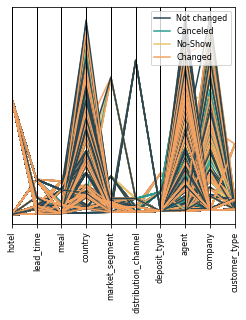

In [5]:
fig, ax = plt.subplots(figsize=(4,4))
pd.plotting.parallel_coordinates(preprocessed_data.select_dtypes(include='object'),'reservation_status',
                                 color=c_palette1)
plt.xticks(rotation='vertical');
ax.get_yaxis().set_visible(False)

<ipython-input-6-cd3ab457c8cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['reservation_status'] = preprocessed_data['reservation_status']
/home/mdanese/.local/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


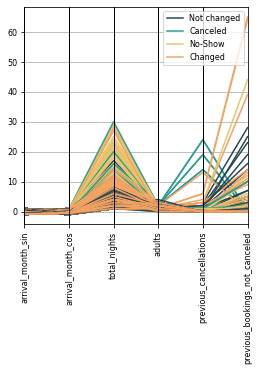

In [6]:
fig, ax = plt.subplots(figsize=(4,4))
tmp = preprocessed_data.select_dtypes(include=['float64', 'int64'])
tmp['reservation_status'] = preprocessed_data['reservation_status']
tmp.drop(columns='arrival_date_year', inplace=True)
pd.plotting.parallel_coordinates(tmp,'reservation_status', color=c_palette1)
plt.xticks(rotation='vertical');

Double check that object columns are nominal:

In [7]:
for col in preprocessed_data:
    if preprocessed_data[col].dtypes == 'object':
        print('\n' +col)
        print(np.unique(preprocessed_data[col]))


hotel
['City Hotel' 'Resort Hotel']

lead_time
['long-term' 'moderate' 'short-term' 'very-long-term' 'very-short-term']

meal
['BB' 'FB' 'HB' 'SC' 'Undefined']

country
['AGO' 'AND' 'ARE' 'ARG' 'AUS' 'AUT' 'AZE' 'BEL' 'BGR' 'BIH' 'BRA' 'CHE'
 'CHL' 'CHN' 'CN' 'COL' 'CPV' 'CUB' 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU'
 'EGY' 'ESP' 'EST' 'FIN' 'FRA' 'GBR' 'GEO' 'GRC' 'GTM' 'HKG' 'HRV' 'HUN'
 'IDN' 'IND' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA' 'JEY' 'JOR' 'JPN' 'KAZ' 'KEN'
 'KOR' 'KWT' 'LBN' 'LTU' 'LUX' 'LVA' 'MAC' 'MAR' 'MCO' 'MEX' 'MLT' 'MOZ'
 'MUS' 'MYS' 'MYT' 'NGA' 'NLD' 'NOR' 'NZL' 'OMN' 'PAK' 'PER' 'PHL' 'POL'
 'PRT' 'QAT' 'ROU' 'RUS' 'SAU' 'SEN' 'SGP' 'SRB' 'SVK' 'SWE' 'THA' 'TMP'
 'TUN' 'TUR' 'TZA' 'UKR' 'URY' 'USA' 'UZB' 'ZAF' 'ZWE']

market_segment
['Aviation' 'Complementary' 'Corporate' 'Direct' 'Groups' 'Offline TA/TO'
 'Online TA']

distribution_channel
['Corporate' 'Direct' 'GDS' 'TA/TO']

deposit_type
['No Deposit' 'Non Refund' 'Refundable']

agent
['1.0' '10.0' '104.0' '105.0' '11.0' '1

In [8]:
df = preprocessed_data.drop(columns=['reservation_status'] , inplace=False)
y = preprocessed_data['reservation_status']
df = pd.get_dummies(df)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=42)


Define validation set

In [9]:
validation_split = np.zeros(len(X_train)).astype('int64')
ind = [random.randrange(0,len(X_train)) for i in range(int(len(validation_split)/10))]
validation_split[ind] = -1
cv = PredefinedSplit(validation_split)

### RF - tuning max_samples only

In [16]:
param_grid = {'max_samples' :[int(np.sqrt(len(X_train)/10)), int(np.sqrt(len(X_train)/5)),
                              int(np.sqrt(len(X_train)/20)), None]
             }
rf = RandomForestClassifier(random_state=42, n_estimators=250, max_depth= 10)
clf = GridSearchCV(rf, param_grid, cv=cv)
clf.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 0, 0])),
             estimator=RandomForestClassifier(max_depth=10, n_estimators=250,
                                              random_state=42),
             param_grid={'max_samples': [20, 29, 14, None]})

In [17]:
clf.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=250, random_state=42)

In [18]:
X_validation = X_train.values[ind]
y_validation = y_train.values[ind]
pd.Series(y_validation)

0         Canceled
1          Changed
2          Changed
3          No-Show
4      Not changed
          ...     
423    Not changed
424    Not changed
425    Not changed
426       Canceled
427        Changed
Length: 428, dtype: object

In [19]:
y_pred = clf.predict(X_validation)
accuracy_score(y_validation, y_pred, normalize=True)

0.8271028037383178

In [20]:
print('f1_score: ', f1_score(y_validation, y_pred, average='micro'))
print('f1_score: ', f1_score(y_validation, y_pred, average='macro'))
print('precision_score: ', precision_score(y_validation, y_pred, average='micro'))
print('precision_score: ', precision_score(y_validation, y_pred, average='macro'))
print('recall_score: ', recall_score(y_validation, y_pred, average='micro'))
print('recall_score: ', recall_score(y_validation, y_pred, average='macro'))


f1_score:  0.8271028037383178
f1_score:  0.8305680042467607
precision_score:  0.8271028037383178
precision_score:  0.8330074150068395
recall_score:  0.8271028037383178
recall_score:  0.83527170661317


# Evaluation - protected data

In [22]:
x_child = X_test[X_test.has_children==True]
x_nochild = X_test[X_test.has_children==False]
y_child = y_test[X_test.has_children==True]
y_nochild = y_test[X_test.has_children==False]


In [23]:
y_pred = clf.predict(x_child)
accuracy_score(y_child, y_pred, normalize=True)

0.7608695652173914

In [24]:
print('f1_score: ', f1_score(y_child, y_pred, average='micro'))
print('precision_score: ', precision_score(y_child, y_pred, average='micro'))
print('recall_score: ', recall_score(y_child, y_pred, average='micro'))

f1_score:  0.7608695652173914
precision_score:  0.7608695652173914
recall_score:  0.7608695652173914


In [25]:
y_pred = clf.predict(x_nochild)
accuracy_score(y_nochild, y_pred, normalize=True)

0.7232558139534884

In [26]:
print('f1_score: ', f1_score(y_nochild, y_pred, average='micro'))
print('precision_score: ', precision_score(y_nochild, y_pred, average='micro'))
print('recall_score: ', recall_score(y_nochild, y_pred, average='micro'))

f1_score:  0.7232558139534884
precision_score:  0.7232558139534884
recall_score:  0.7232558139534884


### RF - tuning all parameters

In [ ]:
param_grid = {'max_depth': [15, 20, 25, 30, 35],
              'min_samples_split': [2, 5, 10],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [100,250, 400],
              'max_samples' :[int(np.sqrt(len(X_train)/10)), int(np.sqrt(len(X_train)/5)),
                              int(np.sqrt(len(X_train)/20)), None]
             }
rf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(rf, param_grid, cv=cv)
clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_

In [ ]:
y_pred = clf.predict(X_validation)
accuracy_score(y_validation, y_pred, normalize=True)

## KNN

In [ ]:
predictors = ['deposit_type', 
              'arrival_month_sin',
              'arrival_month_cos',
              'hotel',
              'total_nights',
              'meal'
             ]
df = preprocessed_data[predictors]
y = preprocessed_data['reservation_status']
df = pd.get_dummies(df)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
param_grid = {'n_neighbors':[3,5,11],
              'weights':['uniform', 'distance']
             }
knn =  KNeighborsClassifier(n_neighbors=3)
clf = GridSearchCV(knn, param_grid)
clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_

In [ ]:
y_pred = clf.predict(X_validation)
accuracy_score(y_validation, y_pred, normalize=True)

### SVC

In [ ]:
param_grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [1, 2, 3]}
svc = SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_

In [ ]:
y_pred = clf.predict(X_validation)
accuracy_score(y_validation, y_pred, normalize=True)

## Logistic

In [ ]:
param_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'C': [1e-1, 1, 10]}
lr = LogisticRegression(solver='sag')
clf = GridSearchCV(lr, param_grid)
clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_

In [ ]:
y_pred = clf.predict(X_validation)
accuracy_score(y_validation, y_pred, normalize=True)